In [2]:
#!/usr/bin/python3
from sklearn.svm import OneClassSVM
import pandas as pd
import feather
from sklearn.model_selection import train_test_split

import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
np.random.seed(500)
import time
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler

In [4]:
pickle_in = open("df_lemma.pickle","rb")
df = pickle.load(pickle_in)

In [5]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,923,0,2014-12-08,3.0,-1,the food at snack is a selection of popular gr...,42,"[the, food, at, snack, is, a, selection, of, p...","['food', 'snack', 'selection', 'popular', 'gre..."
1,923,19,2014-01-14,5.0,-1,the restaurant is on the ground floor of a typ...,95,"[the, restaurant, is, on, the, ground, floor, ...","['restaurant', 'ground', 'floor', 'typical', '..."
2,923,63,2014-11-13,4.0,-1,i really enjoyed brunch at jane. the ambiance ...,35,"[i, really, enjoyed, brunch, at, jane, ., the,...","['really', 'enjoy', 'brunch', 'jane', 'ambianc..."
3,923,100,2014-03-05,4.0,-1,clinton street baking is a super popular baker...,65,"[clinton, street, baking, is, a, super, popula...","['clinton', 'street', 'baking', 'super', 'popu..."
4,923,103,2014-07-28,5.0,-1,thiru has wonderful personality. he has a very...,18,"[thiru, has, wonderful, personality, ., he, ha...","['thiru', 'wonderful', 'personality', 'loyal',..."
...,...,...,...,...,...,...,...,...,...
181350,161143,349,2014-02-19,5.0,1,get the fried brussel sprouts. get the emily p...,55,"[get, the, fried, brussel, sprouts, ., get, th...","['get', 'fried', 'brussel', 'sprout', 'get', '..."
181351,161144,349,2014-02-11,5.0,1,the food was perfect. the wine was perfect. th...,78,"[the, food, was, perfect, ., the, wine, was, p...","['food', 'perfect', 'wine', 'perfect', 'atmosp..."
181352,161145,349,2014-02-09,5.0,1,came here for sunday brunch. everything we tas...,45,"[came, here, for, sunday, brunch, ., everythin...","['come', 'sunday', 'brunch', 'everything', 'ta..."
181353,161146,349,2014-02-06,5.0,1,"i'm very spoiled with pizza. really, i have tr...",280,"[i, 'm, very, spoiled, with, pizza, ., really,...","['spoil', 'pizza', 'really', 'try', 'lucali', ..."


In [6]:
pos=0 
neg = 0

for x in df['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  19174  positive: 162181 total 181355 percent deceptive 10.572633784566182


In [5]:
#file_path = '/home/parallels/KTH/II2202/Data/YelpNYC/database_feather.feather'
#df = pd.read_feather(file_path, columns=None, use_threads=True)

In [7]:
df.dtypes

user_id             int32
prod_id             int32
date               object
rating            float64
label               int32
review_content     object
word_count          int32
tokenized          object
text_final         object
dtype: object

In [8]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,923,0,2014-12-08,3.0,-1,the food at snack is a selection of popular gr...,42,"[the, food, at, snack, is, a, selection, of, p...","['food', 'snack', 'selection', 'popular', 'gre..."
1,923,19,2014-01-14,5.0,-1,the restaurant is on the ground floor of a typ...,95,"[the, restaurant, is, on, the, ground, floor, ...","['restaurant', 'ground', 'floor', 'typical', '..."
2,923,63,2014-11-13,4.0,-1,i really enjoyed brunch at jane. the ambiance ...,35,"[i, really, enjoyed, brunch, at, jane, ., the,...","['really', 'enjoy', 'brunch', 'jane', 'ambianc..."
3,923,100,2014-03-05,4.0,-1,clinton street baking is a super popular baker...,65,"[clinton, street, baking, is, a, super, popula...","['clinton', 'street', 'baking', 'super', 'popu..."
4,923,103,2014-07-28,5.0,-1,thiru has wonderful personality. he has a very...,18,"[thiru, has, wonderful, personality, ., he, ha...","['thiru', 'wonderful', 'personality', 'loyal',..."
...,...,...,...,...,...,...,...,...,...
181350,161143,349,2014-02-19,5.0,1,get the fried brussel sprouts. get the emily p...,55,"[get, the, fried, brussel, sprouts, ., get, th...","['get', 'fried', 'brussel', 'sprout', 'get', '..."
181351,161144,349,2014-02-11,5.0,1,the food was perfect. the wine was perfect. th...,78,"[the, food, was, perfect, ., the, wine, was, p...","['food', 'perfect', 'wine', 'perfect', 'atmosp..."
181352,161145,349,2014-02-09,5.0,1,came here for sunday brunch. everything we tas...,45,"[came, here, for, sunday, brunch, ., everythin...","['come', 'sunday', 'brunch', 'everything', 'ta..."
181353,161146,349,2014-02-06,5.0,1,"i'm very spoiled with pizza. really, i have tr...",280,"[i, 'm, very, spoiled, with, pizza, ., really,...","['spoil', 'pizza', 'really', 'try', 'lucali', ..."


In [8]:
df.describe()

,user_id,prod_id,rating,label,word_count
count,181355.000000,181355.000000,181355.000000,181355.000000,181355.000000
mean,53637.327380,454.388867,4.025205,0.788547,240.641273
std,45732.857076,260.687294,1.057903,0.614976,2992.140353
min,923.000000,0.000000,1.000000,-1.000000,1.000000
25%,13917.000000,245.000000,4.000000,1.000000,46.000000
50%,39608.000000,465.000000,4.000000,1.000000,89.000000
75%,86406.000000,668.000000,5.000000,1.000000,158.000000
max,161147.000000,922.000000,5.000000,1.000000,212038.000000


In [9]:
df.iloc[390,:]

user_id                                                         994
prod_id                                                         251
date                                                     2012-06-01
rating                                                            4
label                                                             1
review_content    since i am a pescatarian and pregnant (pregnan...
word_count                                                      179
tokenized         [since, i, am, a, pescatarian, and, pregnant, ...
text_final        ['since', 'pescatarian', 'pregnant', 'pregnant...
Name: 390, dtype: object

In [10]:
# # Step - a : Remove blank rows if any.
# df['review_content'].dropna(inplace=True)

In [11]:
# # Step - b : Change all the text to lower case
# df['review_content'] = [entry.lower() for entry in df['review_content']]

In [12]:
# # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
# # tokenized = []
# # for index,entry in enumerate(genuine['review_content']): 
# #     genuine.loc[index,'tokenized'] = [word_tokenize(entry)]
# #     percent = index/len(genuine)*100
# #     print('percent done [%d%%]\r'%percent, end="")
# df['tokenized']= [word_tokenize(entry) for entry in df['review_content']]

In [13]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,923,0,2014-12-08,3.0,-1,the food at snack is a selection of popular gr...,42,"[the, food, at, snack, is, a, selection, of, p...","['food', 'snack', 'selection', 'popular', 'gre..."
1,923,19,2014-01-14,5.0,-1,the restaurant is on the ground floor of a typ...,95,"[the, restaurant, is, on, the, ground, floor, ...","['restaurant', 'ground', 'floor', 'typical', '..."
2,923,63,2014-11-13,4.0,-1,i really enjoyed brunch at jane. the ambiance ...,35,"[i, really, enjoyed, brunch, at, jane, ., the,...","['really', 'enjoy', 'brunch', 'jane', 'ambianc..."
3,923,100,2014-03-05,4.0,-1,clinton street baking is a super popular baker...,65,"[clinton, street, baking, is, a, super, popula...","['clinton', 'street', 'baking', 'super', 'popu..."
4,923,103,2014-07-28,5.0,-1,thiru has wonderful personality. he has a very...,18,"[thiru, has, wonderful, personality, ., he, ha...","['thiru', 'wonderful', 'personality', 'loyal',..."
...,...,...,...,...,...,...,...,...,...
181350,161143,349,2014-02-19,5.0,1,get the fried brussel sprouts. get the emily p...,55,"[get, the, fried, brussel, sprouts, ., get, th...","['get', 'fried', 'brussel', 'sprout', 'get', '..."
181351,161144,349,2014-02-11,5.0,1,the food was perfect. the wine was perfect. th...,78,"[the, food, was, perfect, ., the, wine, was, p...","['food', 'perfect', 'wine', 'perfect', 'atmosp..."
181352,161145,349,2014-02-09,5.0,1,came here for sunday brunch. everything we tas...,45,"[came, here, for, sunday, brunch, ., everythin...","['come', 'sunday', 'brunch', 'everything', 'ta..."
181353,161146,349,2014-02-06,5.0,1,"i'm very spoiled with pizza. really, i have tr...",280,"[i, 'm, very, spoiled, with, pizza, ., really,...","['spoil', 'pizza', 'really', 'try', 'lucali', ..."


In [14]:
# # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
# final_text = [None]*len(df['tokenized'])
# for index,entry in enumerate(df['tokenized']):
#     # Declaring Empty List to store the words that follow the rules for this step
#     Final_words = []
#     # Initializing WordNetLemmatizer()
#     percent = float(index/len(df['tokenized'])*100)

#     print('percent done [%f%%]\r'%percent, end="")
#     word_Lemmatized = WordNetLemmatizer()
#     # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#     for word, tag in pos_tag(entry):
#         # Below condition is to check for Stop words and consider only alphabets
#         if word not in stopwords.words('english') and word.isalpha():
#             word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#             Final_words.append(word_Final)
#     # The final processed set of words for each iteration will be stored in 'text_final'
#     df.loc[index,'text_final'] = str(Final_words)
#     final_text[index]=(Final_words)
    
    #print('index ' + str(index) + ' entry ' + str(entry) +  '...final//// '+ str(genuine.loc[index,'text_final']) + '\r')

In [15]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,923,0,2014-12-08,3.0,-1,the food at snack is a selection of popular gr...,42,"[the, food, at, snack, is, a, selection, of, p...","['food', 'snack', 'selection', 'popular', 'gre..."
1,923,19,2014-01-14,5.0,-1,the restaurant is on the ground floor of a typ...,95,"[the, restaurant, is, on, the, ground, floor, ...","['restaurant', 'ground', 'floor', 'typical', '..."
2,923,63,2014-11-13,4.0,-1,i really enjoyed brunch at jane. the ambiance ...,35,"[i, really, enjoyed, brunch, at, jane, ., the,...","['really', 'enjoy', 'brunch', 'jane', 'ambianc..."
3,923,100,2014-03-05,4.0,-1,clinton street baking is a super popular baker...,65,"[clinton, street, baking, is, a, super, popula...","['clinton', 'street', 'baking', 'super', 'popu..."
4,923,103,2014-07-28,5.0,-1,thiru has wonderful personality. he has a very...,18,"[thiru, has, wonderful, personality, ., he, ha...","['thiru', 'wonderful', 'personality', 'loyal',..."
...,...,...,...,...,...,...,...,...,...
181350,161143,349,2014-02-19,5.0,1,get the fried brussel sprouts. get the emily p...,55,"[get, the, fried, brussel, sprouts, ., get, th...","['get', 'fried', 'brussel', 'sprout', 'get', '..."
181351,161144,349,2014-02-11,5.0,1,the food was perfect. the wine was perfect. th...,78,"[the, food, was, perfect, ., the, wine, was, p...","['food', 'perfect', 'wine', 'perfect', 'atmosp..."
181352,161145,349,2014-02-09,5.0,1,came here for sunday brunch. everything we tas...,45,"[came, here, for, sunday, brunch, ., everythin...","['come', 'sunday', 'brunch', 'everything', 'ta..."
181353,161146,349,2014-02-06,5.0,1,"i'm very spoiled with pizza. really, i have tr...",280,"[i, 'm, very, spoiled, with, pizza, ., really,...","['spoil', 'pizza', 'really', 'try', 'lucali', ..."


In [16]:
# to save the preporcessed list

# pickle_out = open("df_lemma.pickle","wb")
# pickle.dump(df, pickle_out)
# pickle_out.close()

In [17]:

# genuine = df.loc[df['label'] == 1]
# genuine = genuine[['text_final','word_count']]

In [18]:
# final_text_trial = []
# for idx, text in enumerate(final_text):
#     final_text_trial.append(str(text))

In [19]:
# final_text_trial

In [20]:
# genuine

In [9]:
Train_X_oc_all, Test_X_oc_all = model_selection.train_test_split(df[['label','text_final']],test_size=0.3)

In [10]:
Train_X_oc_all

,label,text_final
119838,1,"['favorite', 'restaurant', 'ever', 'never', 'r..."
10818,1,"['prosciutto', 'pizza', 'would', 'much', 'good..."
35454,1,"['read', 'hype', 'good', 'one', 'time', 'gimmi..."
111796,1,"['sit', 'bar', 'mintues', 'pm', 'sunday', 'nic..."
140305,1,"['say', 'really', 'want', 'like', 'place', 'li..."
...,...,...
19389,1,"['impress', 'anything', 'music', 'loud', 'drin..."
172305,1,"['minetta', 'great', 'place', 'dine', 'second'..."
44865,1,"['burger', 'actually', 'really', 'good', 'garn..."
148407,1,"['come', 'recently', 'french', 'flatmate', 'ce..."


In [11]:
# genuine training
Train_X, Test_X = model_selection.train_test_split((Train_X_oc_all.loc[(df['label'] == 1)]).text_final,test_size=0.3)


In [12]:
# deceptive training
Train_X_dec, Test_X_dec = model_selection.train_test_split((Train_X_oc_all.loc[(df['label'] == -1)]).text_final,test_size=0.3)

In [13]:
Train_X_dec

84461     ['truly', 'believe', 'dosa', 'best', 'vegetari...
47130     ['great', 'food', 'great', 'people', 'behind',...
158928    ['love', 'sultan', 'twice', 'great', 'environm...
180997    ['love', 'love', 'love', 'great', 'restaurant'...
103777    ['fan', 'artichoke', 'pizza', 'usually', 'open...
                                ...                        
140512    ['understand', 'friend', 'tell', 'place', 'go'...
150927    ['tout', 'many', 'best', 'ny', 'say', 'could',...
101789    ['opinion', 'restaurant', 'one', 'best', 'new'...
132833    ['horrible', 'horrific', 'terrify', 'service',...
79287     ['best', 'ramen', 'nyc', 'think', 'location', ...
Name: text_final, Length: 9383, dtype: object

In [14]:
Test_X

21890     ['go', 'maialino', 'friend', 'last', 'saturday...
48582     ['great', 'dj', 'drink', 'strong', 'happy', 'h...
105643    ['come', 'mom', 'tonight', 'look', 'quick', 'd...
70244     ['overall', 'service', 'friendly', 'efficient'...
174071    ['paper', 'thin', 'crust', 'strong', 'enough',...
                                ...                        
60953     ['mp', 'taverna', 'great', 'place', 'go', 'hap...
68731     ['food', 'good', 'enough', 'care', 'may', 'for...
45833     ['salt', 'fat', 'name', 'pretty', 'much', 'say...
48618     ['day', 'tour', 'statue', 'liberty', 'elli', '...
91462     ['three', 'time', 'definitely', 'plan', 'go', ...
Name: text_final, Length: 34063, dtype: object

In [15]:
Tfidf_vect = TfidfVectorizer(max_features=50000)        
Tfidf_vect.fit(df['text_final'])


Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [16]:
Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])

In [17]:
Test_X_Tfidf_all = Tfidf_vect.transform(df['text_final'])

In [18]:
print(df['text_final'].loc[0])

['food', 'snack', 'selection', 'popular', 'greek', 'dish', 'appetizer', 'tray', 'good', 'greek', 'salad', 'underwhelmed', 'main', 'course', 'table', 'sometimes', 'hard', 'get', 'seat']


In [19]:
print(Tfidf_vect.vocabulary_)

{'food': 14491, 'snack': 39608, 'selection': 37766, 'popular': 32082, 'greek': 16482, 'dish': 10857, 'appetizer': 1673, 'tray': 44769, 'good': 16126, 'salad': 36576, 'underwhelmed': 45864, 'main': 23644, 'course': 8765, 'table': 42506, 'sometimes': 39975, 'hard': 17197, 'get': 15709, 'seat': 37630, 'restaurant': 35249, 'ground': 16641, 'floor': 14316, 'typical': 45357, 'park': 30051, 'slope': 39363, 'brownstone': 4987, 'could': 8726, 'walk': 47718, 'right': 35645, 'know': 21224, 'menu': 24982, 'impressive': 18748, 'many': 24018, 'unique': 46123, 'choice': 7060, 'low': 23134, 'celings': 6380, 'open': 28789, 'kitchen': 21122, 'friendly': 14952, 'service': 37973, 'give': 15883, 'cozy': 8825, 'feel': 13729, 'nice': 27421, 'brunch': 5019, 'complete': 8008, 'mimosa': 25437, 'sangria': 36852, 'would': 48949, 'pupusas': 33399, 'glass': 15915, 'red': 34513, 'wine': 48569, 'poached': 31815, 'egg': 12007, 'french': 14873, 'toast': 44121, 'look': 22964, 'amazing': 1138, 'go': 16036, 'return': 3537

In [20]:
print(Train_X_Tfidf.shape)

(79480, 50000)


In [21]:
Test_X_Tfidf_all.shape

(181355, 50000)

In [22]:
# fit the training dataset on the classifier [deceptive]
start_time = time.time()

clf_dec = OneClassSVM(gamma='auto', kernel='poly', degree=5).fit(Train_X_Tfidf_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 16.47865867614746


In [28]:
# predict using deceptive
start_time = time.time()
predictions_oneclass_dec = clf_dec.predict(Test_X_Tfidf_dec)
print(predictions_oneclass_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

[-1 -1  1 ... -1 -1 -1]
elapsed_time 113.53122186660767


In [30]:
# count of negative and positive for deceptive as training
pos=0 
neg = 0

for x in predictions_oneclass_dec:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)   

negative:  53578  positive: 829


In [29]:
print("Accuracy Score for deceptive as train-> ",accuracy_score(predictions_oneclass_dec*-1, Test_X_oc_all['label'], normalize=True))

Accuracy Score for deceptive as train->  0.887698274119139


In [23]:
# fit the training dataset on the classifier [genuine]
start_time = time.time()

clf_gen = OneClassSVM(gamma='auto', kernel='poly', degree=5).fit(Train_X_Tfidf)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 1700.4449467658997


In [24]:
# predict using genuine
start_time = time.time()
predictions_oneclass_gen = clf_gen.predict(Test_X_Tfidf_dec)
print(predictions_oneclass_gen)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

[-1 -1 -1 ... -1 -1 -1]
elapsed_time 1143.2183482646942


In [25]:
# count of negative and positive for genuine as training
pos=0 
neg = 0

for x in predictions_oneclass_gen:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)       

negative:  54346  positive: 61


In [26]:

print("Accuracy Score for genuine as train-> ",accuracy_score(predictions_oneclass_gen, Test_X_oc_all['label'], normalize=True))

Accuracy Score for genuine as train->  0.10678772952009852


In [ ]:
# # fit the training dataset on the classifier
# start_time = time.time()

# clf = OneClassSVM(gamma='auto',).fit(Train_X_Tfidf)
# elapsed_time = time.time() - start_time
# print('elapsed_time' , elapsed_time)
# # predict the labels on validation dataset

In [ ]:
# # to save the classifier model

# pickle_out = open("clf_oneclass.pickle","wb")
# pickle.dump(clf, pickle_out)
# pickle_out.close()

In [ ]:
df

In [120]:
array = df.values

X = Tfidf_vect.transform(df['text_final'])
Y = array[:,4]
Y=Y.astype(str)
X_train_all, X_validation_all, Y_train_all, Y_validation_all = train_test_split(X, Y, test_size=0.30, random_state=1)

In [ ]:
Y

In [121]:
# classifier checker

# your code
models = []
#models.append(['Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr'),[],0,0])
#models.append(['Linear Discriminant Analysis', LinearDiscriminantAnalysis(),[],0,0])
#models.append(['K Nearest Neighbor', KNeighborsClassifier(),[],0,0])
#models.append(['Decesion Tree Classifier', DecisionTreeClassifier(),[],0,0])
#models.append(['Gaussien Naive Bayes', GaussianNB(),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',verbose=True),[],0,0])
#models.append(['Random Forest', RandomForestClassifier(max_depth = 1000,random_state=1),[],0,0])

models = np.array(models,dtype=object)

for i in range(len(models)):
    start_time = time.time()
    kfold = StratifiedKFold(n_splits=2, random_state=1, shuffle=True)
    cv_results = cross_val_score(models[i,1], X_train_all, Y_train_all, cv=kfold, scoring='accuracy')
    models[i,2] = cv_results
    models[i,3] = cv_results.mean()
    models[i,4] = cv_results.std()
    elapsed_time = time.time() - start_time
    print('%s: %f (%f) elapsed time: %f' % (models[i,0], models[i,3], models[i,4],elapsed_time))
    
    

best_model= models[np.argmax(models[:,3]),:]
print("the best model performer is: ", best_model[0])

[LibSVM][LibSVM]Support Vector Machine: 0.894303 (0.000000) elapsed time: 1683.564678
the best model performer is:  Support Vector Machine


In [ ]:
clf_model=LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train_all, Y_train_all)

In [ ]:
result=clf_model.predict(X_validation_all)

In [ ]:
print("Accuracy Score -> ",accuracy_score(result, Y_validation_all, normalize=True))

[   0    1    2 ... 4689 4690 4691]
[204530]


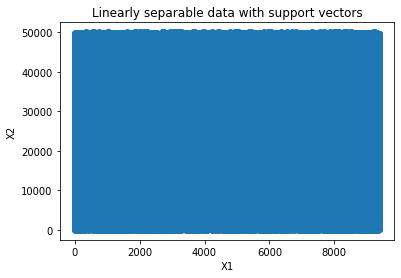

In [96]:
#visualize svm
# Get support vector indices
support_vector_indices = clf_dec.support_
print(support_vector_indices)
# Get number of support vectors per class
support_vectors_per_class = clf_dec.n_support_
print(support_vectors_per_class)
# Get support vectors themselves
support_vectors = clf_dec.support_vectors_

# Visualize support vectors
Train_X_Tfidf_dec_mtlb = Train_X_Tfidf_dec.todok()
xy = np.array(list(Train_X_Tfidf_dec_mtlb.keys()))
vals = np.array(list(Train_X_Tfidf_dec_mtlb.values()))

plt.scatter(xy[:,0], xy[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [116]:
# fit the training dataset on the classifier
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [2,3,5,7,9]
classifiers = []
for kern in kernels:
    start_time = time.time()
    if kern == 'poly':
        for deg in degrees:
            start_time = time.time()
            clf_result = OneClassSVM(gamma='auto', kernel=kern, degree=deg).fit(Train_X_Tfidf_dec)
            elapsed_time = time.time() - start_time
            classifiers.append([kern,deg,clf_result,elapsed_time])
            print('kernel used: ' , kern, ' degree used: ' , deg, ' elapsed_time:' , elapsed_time)
            
    else:
        clf_result = OneClassSVM(gamma='auto', kernel=kern).fit(Train_X_Tfidf_dec)
        elapsed_time = time.time() - start_time
        classifiers.append([kern,0,clf_result,elapsed_time])
        print('kernel used: ' , kern, ' elapsed_time: ' , elapsed_time)

# predict the labels on validation dataset

kernel used:  linear  elapsed_time:  24.360371828079224
kernel used:  poly  degree used:  2  elapsed_time: 14.685479640960693
kernel used:  poly  degree used:  3  elapsed_time: 14.629916906356812
kernel used:  poly  degree used:  5  elapsed_time: 15.76375412940979
kernel used:  poly  degree used:  7  elapsed_time: 15.06252408027649
kernel used:  poly  degree used:  9  elapsed_time: 14.879133939743042
kernel used:  rbf  elapsed_time:  22.34223437309265
kernel used:  sigmoid  elapsed_time:  18.294121265411377


In [117]:
clas_result = []
for clas in classifiers:
    start_time = time.time()
    predict_result = clas[2].predict(Test_X_Tfidf_dec)
    elapsed_time = time.time() - start_time
    clas_result.append([clas[0],clas[1],clas[2],predict_result])
    acc = accuracy_score(predict_result*-1, Test_X_oc_all['label'], normalize=True)
    print('kernel used: ' , clas[0], ' degree used:' , clas[1], ' elapsed_time: ' , elapsed_time, ' accuracy: ', acc)
            

# predict the labels on validation dataset

kernel used:  linear  degree used: 0  elapsed_time:  78.73259711265564  accuracy:  0.47021522965794843
kernel used:  poly  degree used: 2  elapsed_time:  99.11112689971924  accuracy:  0.3285239031742239
kernel used:  poly  degree used: 3  elapsed_time:  110.92524671554565  accuracy:  0.6569007664454941
kernel used:  poly  degree used: 5  elapsed_time:  106.89561581611633  accuracy:  0.887698274119139
kernel used:  poly  degree used: 7  elapsed_time:  101.05183720588684  accuracy:  0.8924770709651332
kernel used:  poly  degree used: 9  elapsed_time:  111.14903402328491  accuracy:  0.8931938904920322
kernel used:  rbf  degree used: 0  elapsed_time:  88.13708329200745  accuracy:  0.5846306541437682
kernel used:  sigmoid  degree used: 0  elapsed_time:  86.91821789741516  accuracy:  0.2878673700075358
